# Answers assignment 1 (Block Maxima)

/var/folders/4r/myg3jzhx1yd72kbqs5r4rv2w0000gn/T/ipykernel_4326/3084768505.py:16: FutureWarning: 'A-DEC' is deprecated and will be removed in a future version, please use 'YE-DEC' instead.
  annual_max = df['Hs'].resample('A-DEC').max().dropna()


Annual maxima (first rows):
datetime
2005    4.492676
2006    3.765381
2007    2.553467
2008    3.995605
2009    4.979492
Name: Hs, dtype: float64 

GEV fit parameters:
  location μ = 3.8009
  scale    σ = 0.8021
  shape    ξ = -0.2187  (note: SciPy returns c = -ξ)

100.0-year return value: 6.1271


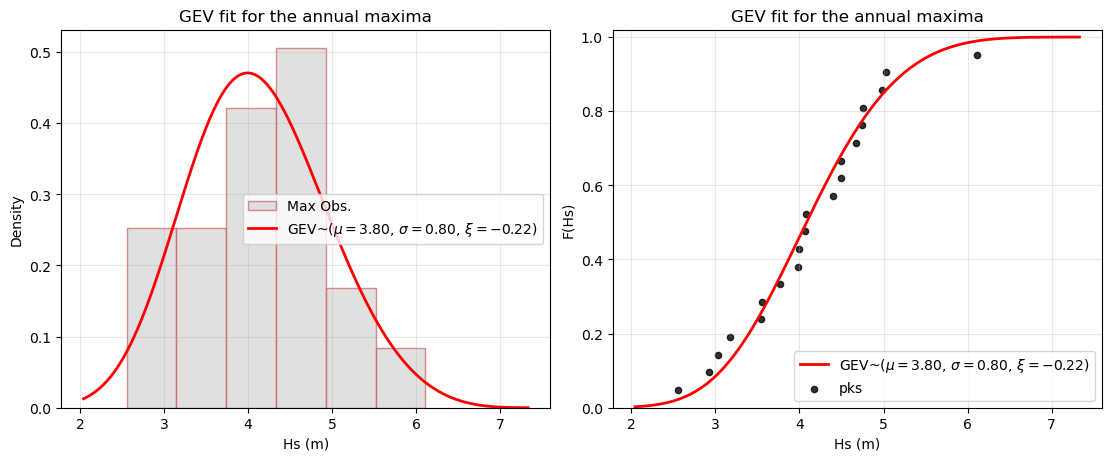

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1) Load and tidy
# Adjust the path if your CSV lives elsewhere
df = pd.read_csv('Wavedata.csv')

# Parse datetime (day-first, as in 01/01/2005 03:00), ensure numeric Hs
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df['Hs'] = pd.to_numeric(df['Hs'], errors='coerce')
df = df.dropna(subset=['datetime', 'Hs']).sort_values('datetime').set_index('datetime')

# 2) Block maxima: annual maxima
annual_max = df['Hs'].resample('A-DEC').max().dropna()
# If you prefer calendar year labels:
annual_max.index = annual_max.index.year

print('Annual maxima (first rows):')
print(annual_max.head(), '\n')

# 3) Fit GEV to annual maxima
# SciPy's genextreme uses parameter c which equals -xi in the common GEV notation
c, loc, scale = stats.genextreme.fit(annual_max.values)
xi = -c
mu = loc
sigma = scale

print(f'GEV fit parameters:')
print(f'  location μ = {mu:.4f}')
print(f'  scale    σ = {sigma:.4f}')
print(f'  shape    ξ = {xi:.4f}  (note: SciPy returns c = -ξ)\n')

# 4) 100-year return value for annual maxima
def gev_return_level(T, mu, sigma, xi):
    # T in years for annual block maxima
    p = 1.0 - 1.0 / T
    if np.isclose(xi, 0.0):
        # Gumbel limit
        return mu - sigma * np.log(-np.log(p))
    else:
        return mu + (sigma / xi) * ((-np.log(p))**(-xi) - 1.0)

T = 100.  # Return period in years

z_T = gev_return_level(T, mu, sigma, xi)
print(f'{T}-year return value: {z_T:.4f}')

# 5) Plots: pdf on histogram (left) and cdf with empirical points (right)

# x-grid for smooth curves
x = np.linspace(annual_max.min()*0.8, annual_max.max()*1.2, 500)

# Fitted pdf and cdf using SciPy's parameterisation (c = -xi)
pdf_fit = stats.genextreme.pdf(x, c, loc=mu, scale=sigma)
cdf_fit = stats.genextreme.cdf(x, c, loc=mu, scale=sigma)

# Empirical cdf (Weibull plotting positions)
s = np.sort(annual_max.values)
n = s.size
p_emp = np.arange(1, n+1) / (n + 1.0)

fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), constrained_layout=True)

# Left: histogram + pdf
ax = axes[0]
ax.hist(annual_max.values, bins='auto', density=True,
        facecolor='lightgrey', edgecolor='indianred', alpha=0.7, label='Max Obs.')
ax.plot(x, pdf_fit, color='red', lw=2,
        label=fr'GEV~$(\mu={mu:.2f},\, \sigma={sigma:.2f},\, \xi={xi:.2f})$')
ax.set_xlabel('Hs (m)')
ax.set_ylabel('Density')
ax.set_title('GEV fit for the annual maxima')
ax.legend(frameon=True)
ax.grid(alpha=0.3)

# Right: empirical cdf + fitted cdf
ax = axes[1]
ax.plot(x, cdf_fit, color='red', lw=2,
        label=fr'GEV~$(\mu={mu:.2f},\, \sigma={sigma:.2f},\, \xi={xi:.2f})$')
ax.scatter(s, p_emp, s=20, color='black', alpha=0.8, label='pks')
ax.set_xlabel('Hs (m)')
ax.set_ylabel('F(Hs)')
ax.set_title('GEV fit for the annual maxima')
ax.set_ylim(0, 1.02)
ax.grid(alpha=0.3)
ax.legend(frameon=True)

plt.show()


# Answers assignment 2 (Peak-over-threshold)

Number of exceedance clusters: 101
First few peak times and values:
2005-01-26 06:00:00    2.823242
2005-02-09 21:00:00    3.108154
2005-03-01 18:00:00    3.377686
2005-04-10 15:00:00    2.634033
2005-12-11 06:00:00    2.703857
dtype: float64

GPD fit parameters (exceedances):
  scale  β = 0.7155
  shape  ξ = -0.0209
  loc    = 0.0000 (fixed at 0)

Estimated rate of exceedance: 5.050 per year
100-year return value (exact Poisson formula): 6.6732 m

Upper end-point of the model (xi < 0): 36.7453 m



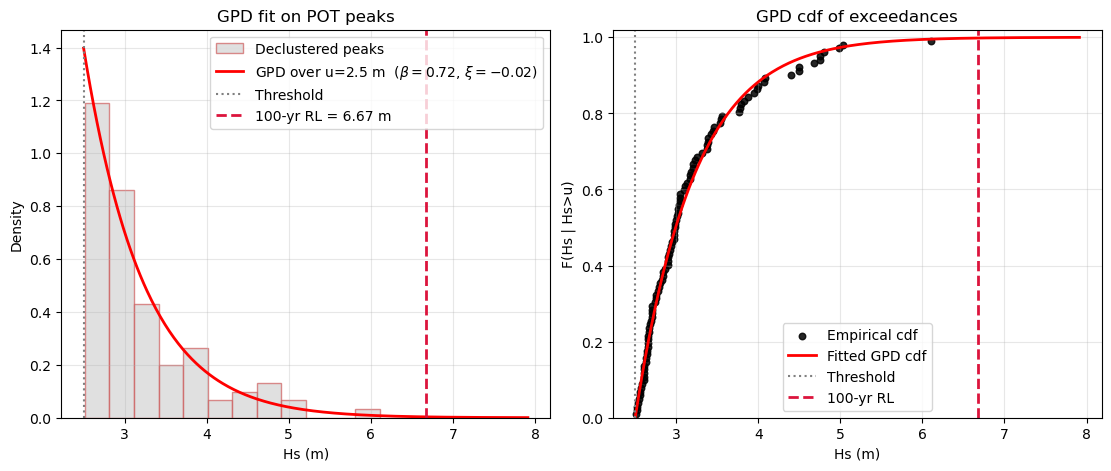

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# -----------------------------
# 1) Load data and set POT knobs
# -----------------------------
u = 2.5                     # threshold [m]
dl_hours = 48               # declustering window [hours]
T = 100.0                   # return period in years

df = pd.read_csv('Wavedata.csv')  # adjust path if needed
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=True)
df['Hs'] = pd.to_numeric(df['Hs'], errors='coerce')
df = df.dropna(subset=['datetime', 'Hs']).sort_values('datetime').set_index('datetime')

# -------------------------------------------------------
# 2) Extract peaks over threshold with declustering (48 h)
#    - keep only the local maximum within each cluster
# -------------------------------------------------------
exc = df.loc[df['Hs'] > u, 'Hs']  # raw exceedances
if exc.empty:
    raise ValueError("No values exceed the threshold. Choose a lower u.")

# New cluster starts when the time gap since the previous exceedance > dl_hours
clusters = (exc.index.to_series().diff() > pd.Timedelta(hours=dl_hours)).cumsum()

# One peak per cluster: the maximum within that cluster
peaks = exc.groupby(clusters).max()
peak_times = exc.groupby(clusters).idxmax()

print(f'Number of exceedance clusters: {len(peaks)}')
print(f'First few peak times and values:\n{pd.Series(peaks.values, index=peak_times.values).head()}\n')

# -------------------------------------------------------
# 3) Fit GPD to exceedance magnitudes Y = X - u
# -------------------------------------------------------
y = (peaks - u).values
# SciPy's genpareto: c is xi, loc is usually fixed at 0 for exceedances
xi, loc, beta = stats.genpareto.fit(y, floc=0.0)
print('GPD fit parameters (exceedances):')
print(f'  scale  β = {beta:.4f}')
print(f'  shape  ξ = {xi:.4f}')
print(f'  loc    = {loc:.4f} (fixed at 0)\n')

# -------------------------------------------------------
# 4) 100-year return value using a Poisson rate of exceedances
# -------------------------------------------------------
# Estimate exceedance rate per year from the declustered peaks
years = (df.index.max() - df.index.min()) / pd.Timedelta(days=365.25)
rate = len(peaks) / float(years)

def gpd_return_level(T, u, beta, xi, rate, exact=True):
    """
    Return level for POT with exceedance rate 'rate' per year.
    exact=True uses the Poisson-exact formula.
    """
    if exact:
        # P(M <= z_T) = 1 - 1/T = exp(- rate * S(y_T)), with S(y) = 1 - G(y)
        S = -np.log(1.0 - 1.0/T) / rate  # survivor probability per exceedance
        if np.isclose(xi, 0.0):
            yT = -beta * np.log(S)
        else:
            yT = (beta/xi) * (S**(-xi) - 1.0)
    else:
        # Large-T approximation: S ≈ 1/(rate*T)
        S = 1.0 / (rate * T)
        if np.isclose(xi, 0.0):
            yT = beta * np.log(1.0/S)
        else:
            yT = (beta/xi) * ((rate*T)**xi - 1.0)
    return u + yT

z_T = gpd_return_level(T, u, beta, xi, rate, exact=True)
print(f'Estimated rate of exceedance: {rate:.3f} per year')
print(f'{int(T)}-year return value (exact Poisson formula): {z_T:.4f} m\n')

# Optional: finite upper end-point if xi < 0
if xi < 0:
    x_max = u - beta/xi
    print(f'Upper end-point of the model (xi < 0): {x_max:.4f} m\n')

# -------------------------------------------------------
# 5) Quick diagnostics: histogram+pdf and cdf for peaks
# -------------------------------------------------------
# Work in the original Hs scale for plotting
# Grid limited by support if xi < 0
y_max_support = np.inf if xi >= 0 else max(0.0, -beta/xi * 0.99)
y_max = y.max()
y_grid_max = min(y_max*1.5 if np.isfinite(y_max) else 1.0, y_max_support if np.isfinite(y_max_support) else y_max*1.5)
y_grid_max = max(y_grid_max, y.max()*1.2 + 1e-9)
yg = np.linspace(0, y_grid_max, 400)
xg = u + yg

pdf_g = stats.genpareto.pdf(yg, xi, loc=0, scale=beta)
cdf_g = stats.genpareto.cdf(yg, xi, loc=0, scale=beta)

# Empirical cdf for peaks in Hs
s = np.sort(peaks.values)
n = s.size
p_emp = np.arange(1, n+1) / (n + 1.0)

fig, axes = plt.subplots(1, 2, figsize=(11, 4.6), constrained_layout=True)

# Left: histogram of peaks in Hs with fitted GPD pdf on Hs scale
ax = axes[0]
ax.hist(peaks.values, bins='auto', density=True, facecolor='lightgrey',
        edgecolor='indianred', alpha=0.7, label='Declustered peaks')
ax.plot(xg, pdf_g, color='red', lw=2,
        label=fr'GPD over u={u} m  $(\beta={beta:.2f},\, \xi={xi:.2f})$')
ax.axvline(u, color='grey', ls=':', lw=1.5, label='Threshold')
ax.axvline(z_T, color='crimson', ls='--', lw=2, label=fr'{int(T)}-yr RL = {z_T:.2f} m')
ax.set_xlabel('Hs (m)')
ax.set_ylabel('Density')
ax.set_title('GPD fit on POT peaks')
ax.legend(frameon=True)
ax.grid(alpha=0.3)

# Right: empirical cdf of peaks and fitted GPD cdf shown in Hs scale
ax = axes[1]
ax.scatter(s, p_emp, s=22, color='black', alpha=0.85, label='Empirical cdf')
ax.plot(xg, cdf_g, color='red', lw=2, label='Fitted GPD cdf')
ax.axvline(u, color='grey', ls=':', lw=1.5, label='Threshold')
ax.axvline(z_T, color='crimson', ls='--', lw=2, label=fr'{int(T)}-yr RL')
ax.set_xlabel('Hs (m)')
ax.set_ylabel('F(Hs | Hs>u)')
ax.set_ylim(0, 1.02)
ax.set_title('GPD cdf of exceedances')
ax.legend(frameon=True)
ax.grid(alpha=0.3)

plt.show()